### ДЗ1.  Создание и нормализация базы данных
### №1. Схема БД (ссылка на странице дз для отрисовки не открывалась-пришлось делать в таком виде)
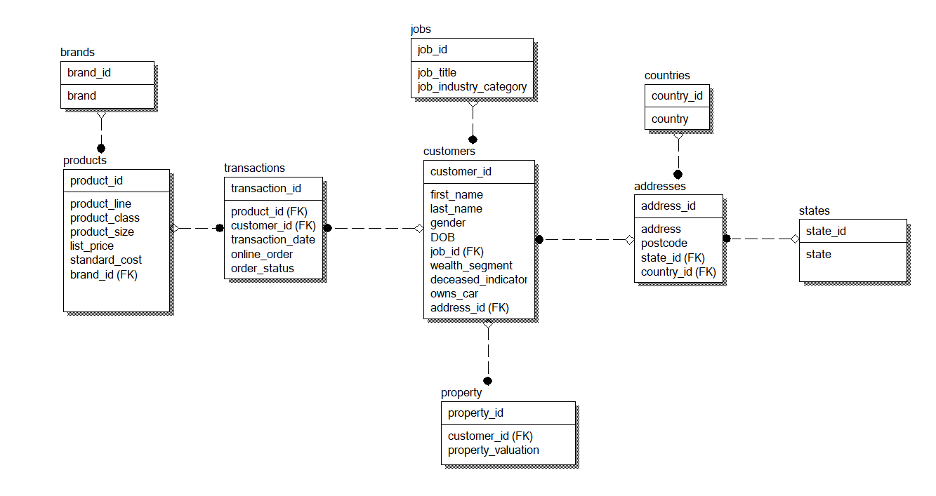
### №2. Нормализация БД (1НФ-3НФ)
Первая нормальная форма
Таблица находится в первой нормальной форме (1NF), если:
1.	каждая ячейка содержит атомарное значение.
2.	нет повторяющихся групп или массивов.
Анализ исходной структуры:
Исходные таблицы customers и transactions уже находятся в 1NF, так как
все значения в ячейках атомарны и нет повторяющихся групп или массивов.

Вторая нормальная форма
Таблица находится во второй нормальной форме (2NF), если:
1.	она находится в 1NF.
2.	все неключевые атрибуты полностью зависят от первичного ключа (нет частичной зависимости).
Таблица customers:
•	атрибуты state, country, address, postcode зависят от customer_id, но они также могут быть выделены в отдельные сущности для устранения избыточности.
•	атрибуты job_title и job_industry_category зависят друг от друга, но не напрямую от customer_id.
Таблица transactions: атрибуты brand, product_line, product_class, product_size, list_price зависят от product_id, но хранятся в таблице transactions, что создает избыточность.
Для приведения таблиц к 2НФ вынесим указанные атрибуты в отдельные таблицы: states, countries, addresse,s jobs brands, products 

Третья нормальная форма
Таблица находится в третьей нормальной форме (3NF), если:
1.	она находится в 2NF.
2.	нет транзитивных зависимостей (неключевые атрибуты зависят только от первичного ключа).
Атрибут property_valuation таблицы customers зависит от customer_id, но может быть выделен в отдельную таблицу для гибкости.
Атрибуты online_order и order_status  таблицы transactions зависят от transaction_id, но могут быть выделены в отдельную таблицу для расширяемости (например, если нужно добавить дополнительные статусы заказа).
### №3. Создание БД (оформил тут и в юпитере на всякий случай)
Создание таблицы states:
CREATE TABLE states (
    state_id SERIAL PRIMARY KEY,
    state VARCHAR(30) NOT NULL UNIQUE
);

 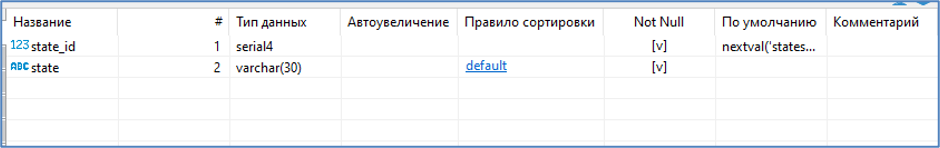

Создание таблицы countries:
CREATE TABLE countries (
    country_id SERIAL PRIMARY KEY,
    country VARCHAR(30) NOT NULL UNIQUE

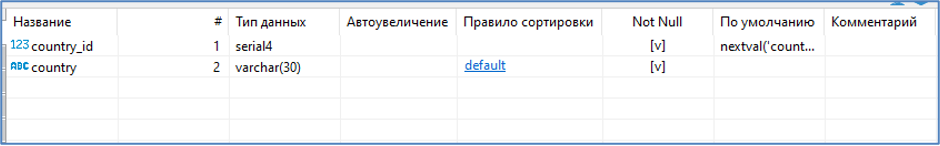

Создание таблицы addresses:
CREATE TABLE addresses (
    address_id SERIAL PRIMARY KEY,
    address VARCHAR(100) NOT NULL,
    postcode CHAR(4),
    state_id INT REFERENCES states(state_id) ON DELETE SET NULL,
    country_id INT REFERENCES countries(country_id) ON DELETE SET NULL);

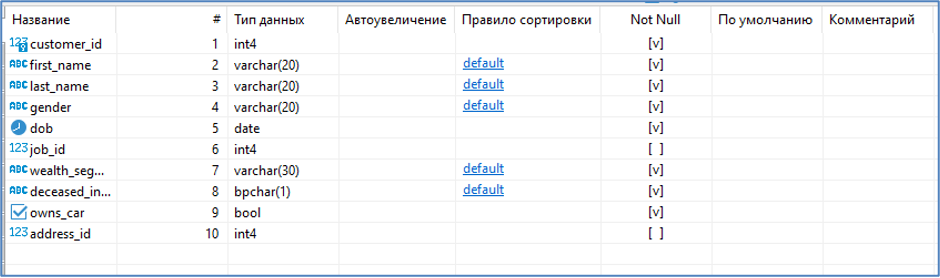

Создание таблицы jobs:
CREATE TABLE jobs (
    job_id SERIAL PRIMARY KEY,
    job_title VARCHAR(255) NOT NULL,
    job_industry_category VARCHAR(255)
);

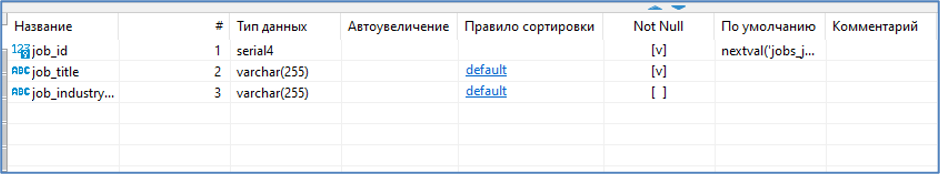

Создание таблицы brands
CREATE TABLE brands (
    brand_id SERIAL PRIMARY KEY,
    brand VARCHAR(30) NOT NULL UNIQUE
);

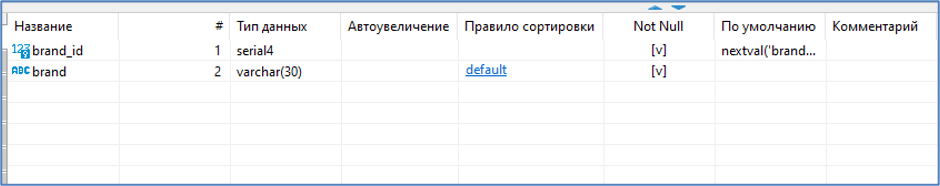

Создание таблицы products:
CREATE TABLE products (
    product_id INT PRIMARY KEY,
    product_line VARCHAR(30),
    product_class VARCHAR(30),
    product_size VARCHAR(30),
    list_price NUMERIC(10, 2),
    standard_cost NUMERIC(10, 2),
    brand_id INT REFERENCES brands(brand_id) ON DELETE SET NULL
);

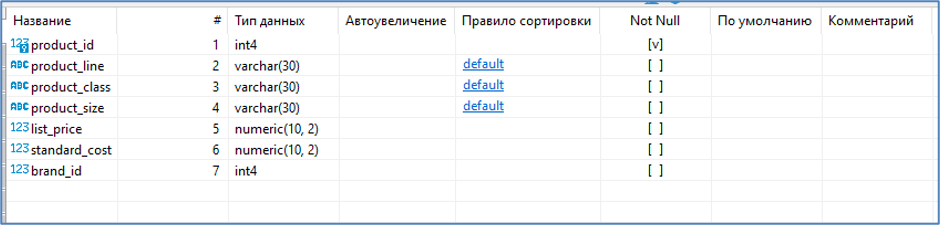

Создание таблицы customers:
CREATE TABLE customers (
    customer_id INT PRIMARY KEY,
    first_name VARCHAR(20) NOT NULL,
    last_name VARCHAR(20) NOT NULL,
    gender VARCHAR(20) NOT NULL,
    DOB DATE NOT NULL,
    job_id INT REFERENCES jobs(job_id) ON DELETE SET NULL,
    wealth_segment VARCHAR(30) NOT NULL,
    deceased_indicator char(1)NOT NULL,
    owns_car BOOLEAN NOT NULL,
    address_id INT REFERENCES addresses(address_id) ON DELETE SET NULL
);

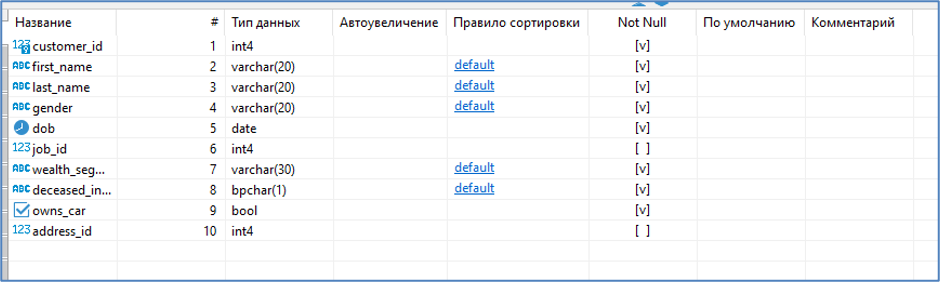

Создание таблицы property:
CREATE TABLE property (
    property_id SERIAL PRIMARY KEY,
    customer_id INT REFERENCES customers(customer_id) ON DELETE CASCADE,
    property_valuation INT NOT NULL
);

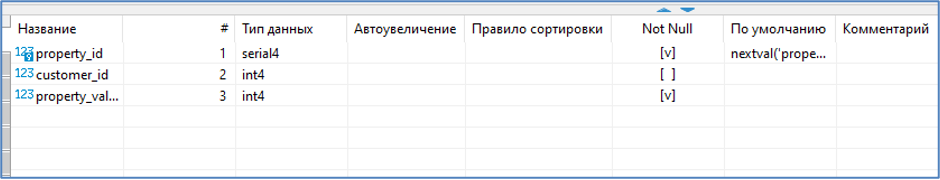

Создание таблицы transactions:
CREATE TABLE transactions (
    transaction_id INT PRIMARY KEY,
    product_id INT REFERENCES products(product_id) ON DELETE SET NULL,
    customer_id INT REFERENCES customers(customer_id) ON DELETE SET NULL,
    transaction_date DATE NOT NULL,
    online_order BOOLEAN NOT NULL,
    order_status VARCHAR(30) NOT NULL
);

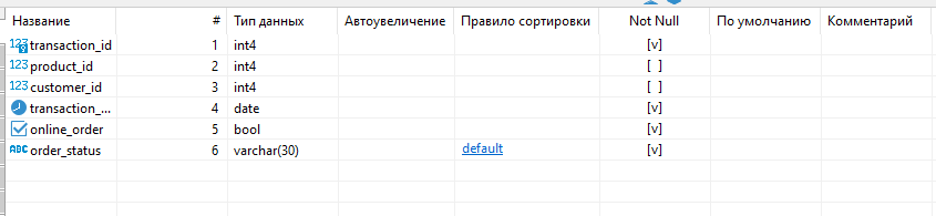

### №4. Заполнение таблиц данными 
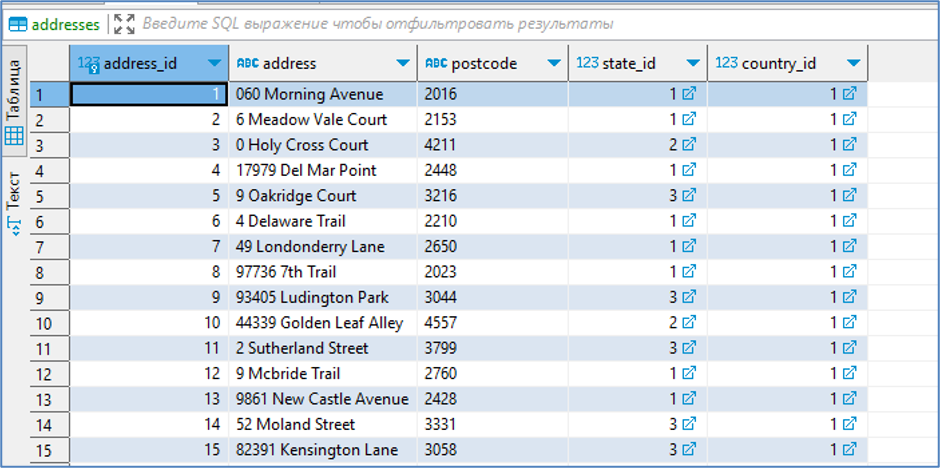

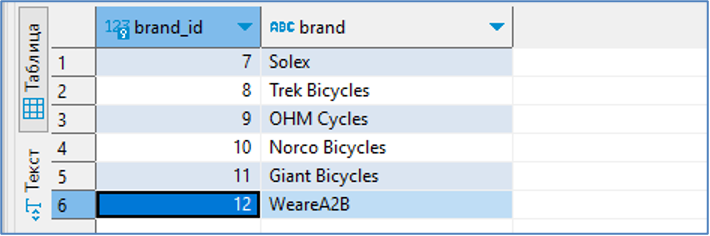

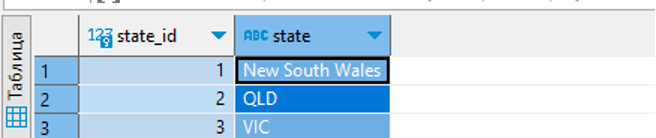

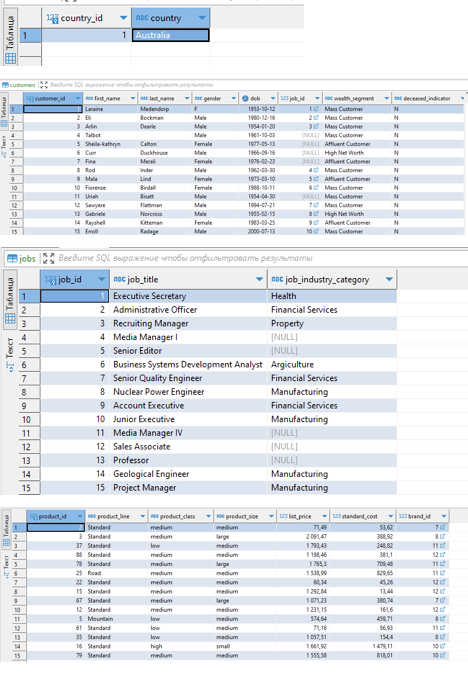

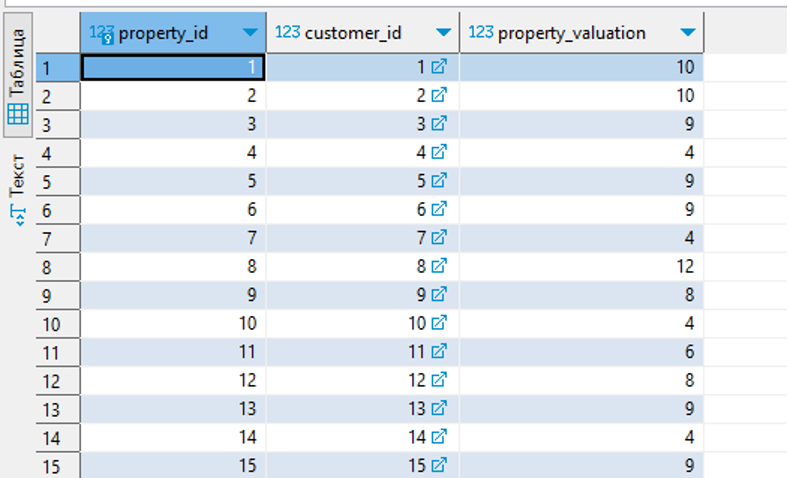

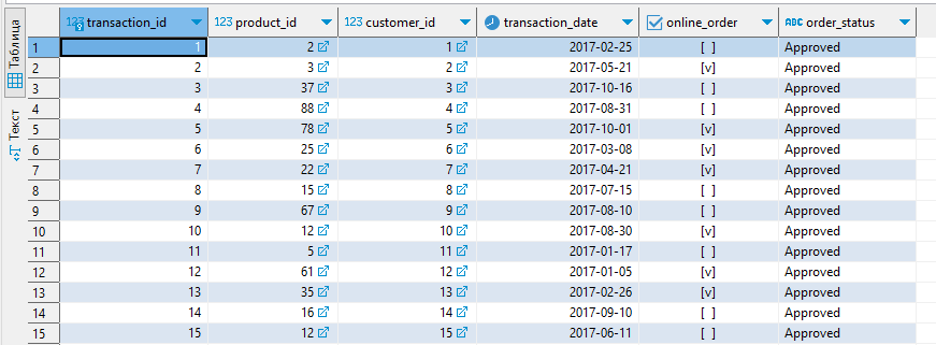

In [42]:
import pandas as pd
import psycopg2 as pg
import numpy as np

In [44]:
conn = pg.connect(dbname='postgres', host='localhost', user='postgres', password='Milya2001!!!!!', port=5432)
cursor = conn.cursor()

In [46]:
excel_file = '/Users/Fakhretdinov/Downloads/customer_and_transaction.xlsx'
df = pd.read_excel(excel_file, sheet_name=['transaction', 'customer'])

In [47]:
df_customers = df['customer']
df_transactions = df['transaction']

In [48]:
for _, row in df_customers.iterrows():
    cursor.execute("""
        INSERT INTO states (state) VALUES (%s)
        ON CONFLICT (state_id) DO NOTHING;
    """, (row['state'],))
conn.commit()

In [1]:
for _, row in df_customers.iterrows():
    cursor.execute("""
        INSERT INTO countries (country) VALUES (%s)
        ON CONFLICT (country_id) DO NOTHING;
    """, (row['country'],))
conn.commit()

In [ ]:
for _, row in df_customers.iterrows():
    # Get state_id and country_id
    cursor.execute("SELECT state_id FROM states WHERE state = %s;", (row['state'],))
    state_id = cursor.fetchone()
    state_id = state_id[0] if state_id else None

    cursor.execute("SELECT country_id FROM countries WHERE country = %s;", (row['country'],))
    country_id = cursor.fetchone()
    country_id = country_id[0] if country_id else None

    cursor.execute("""
        INSERT INTO addresses (address, postcode, state_id, country_id) 
        VALUES (%s, %s, %s, %s)
        ON CONFLICT (address_id) DO NOTHING;
    """, (row['address'], row['postcode'], state_id, country_id))
conn.commit()

In [ ]:
for _, row in df_customers.iterrows():
    cursor.execute("""
        INSERT INTO jobs (job_title, job_industry_category) VALUES (%s, %s)
        ON CONFLICT (job_id) DO NOTHING;
    """, (row['job_title'], row['job_industry_category']))
conn.commit()

In [ ]:
for _, row in df_transactions.iterrows():
    cursor.execute("""
        INSERT INTO brands (brand) VALUES (%s)
        ON CONFLICT (brand_id) DO NOTHING;
    """, (row['brand'],))
conn.commit()

In [ ]:
print(df_transactions['brand'].unique())  

In [ ]:
df_transactions['brand'] = df_transactions['brand'].fillna('Unknown Brand').str.strip()

for _, row in df_transactions.iterrows():
    # Fetch brand_id from the brands table
    cursor.execute("SELECT brand_id FROM brands WHERE brand = %s;", (row['brand'],))
    brand_id = cursor.fetchone()

    if brand_id is not None:
        brand_id = int(brand_id[0])  
    else: 
        continue 

    row_values = (
        row['product_id'], 
        row['product_line'], 
        row['product_class'], 
        row['product_size'], 
        None if pd.isna(row['list_price']) else row['list_price'],
        None if pd.isna(row['standard_cost']) else row['standard_cost'],
        brand_id
    )

    cursor.execute("""
        INSERT INTO products (product_id, product_line, product_class, product_size, list_price, standard_cost, brand_id) 
        VALUES (%s, %s, %s, %s, %s, %s, %s)
        ON CONFLICT (product_id) DO NOTHING;
    """, row_values)


conn.commit()



In [ ]:
for _, row in df_customers.iterrows():
    job_title = row['job_title'] if pd.notnull(row['job_title']) else None

    if job_title:
        cursor.execute("SELECT job_id FROM jobs WHERE job_title = %s;", (job_title,))
        job_id = cursor.fetchone()
        job_id = job_id[0] if job_id is not None else 1  
    else:
        job_id = 1  # assign "Unknown Job"

    cursor.execute("SELECT address_id FROM addresses WHERE address = %s;", (row['address'],))
    address_id = cursor.fetchone()
    address_id = address_id[0] if address_id is not None else None

    if address_id is None:
        continue

    gender = str(row['gender']).strip().title() if pd.notnull(row['gender']) else 'Unknown'
    if gender not in ['Male', 'Female']:
        gender = 'Unknown' 

    dob = pd.to_datetime(row['DOB']).date() if pd.notnull(row['DOB']) else None

    owns_car = True if str(row['owns_car']).strip().lower() == 'yes' else False

    cursor.execute("""
        INSERT INTO customers (customer_id, first_name, last_name, gender, DOB, job_id, wealth_segment, deceased_indicator, owns_car, address_id)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
        ON CONFLICT (customer_id) DO UPDATE SET
            gender = EXCLUDED.gender;
    """, (
        row['customer_id'], row['first_name'], row['last_name'], gender,
        dob, job_id, row['wealth_segment'], row['deceased_indicator'], owns_car, address_id
    ))

conn.commit()


In [ ]:
for _, row in df_customers.iterrows():
    cursor.execute("SELECT customer_id FROM customers WHERE customer_id = %s;", (row['customer_id'],))
    customer_id = cursor.fetchone()
    customer_id = customer_id[0] if customer_id is not None else None

    if customer_id is None:
        print(f"Skipping property entry due to missing customer_id: {row['customer_id']}")
        continue

    property_valuation = int(row['property_valuation']) if pd.notnull(row['property_valuation']) else None

    cursor.execute("""
        INSERT INTO property (customer_id, property_valuation)
        VALUES (%s, %s)
        ON CONFLICT DO NOTHING;
    """, (customer_id, property_valuation))

conn.commit()


In [ ]:
for _, row in df_transactions.iterrows():
        transaction_id = int(row['transaction_id']) if pd.notnull(row['transaction_id']) else None
        if transaction_id is None:
            print("skipping due to missing transaction_id.")
            continue

        cursor.execute("SELECT customer_id FROM customers WHERE customer_id = %s;", (row['customer_id'],))
        customer_id = cursor.fetchone()
        customer_id = customer_id[0] if customer_id is not None else None

        if customer_id is None:
            print(f"skipping transaction {transaction_id} due to missing customer_id: {row['customer_id']}")
            continue

        cursor.execute("SELECT product_id FROM products WHERE product_id = %s;", (row['product_id'],))
        product_id = cursor.fetchone()
        product_id = product_id[0] if product_id is not None else None

        if product_id is None:
            print(f"skipping transaction {transaction_id} due to missing product_id: {row['product_id']}")
            continue

        transaction_date = pd.to_datetime(row['transaction_date']).date() if pd.notnull(row['transaction_date']) else None


        online_order = str(row['online_order']).strip().lower() if pd.notnull(row['online_order']) else None
        online_order = True if online_order == 'true' else False

        order_status = str(row['order_status']).strip().title() if pd.notnull(row['order_status']) else 'Unknown'

        cursor.execute("""
            INSERT INTO transactions (transaction_id, product_id, customer_id, transaction_date, online_order, order_status)
            VALUES (%s, %s, %s, %s, %s, %s)
            ON CONFLICT (transaction_id) DO UPDATE
            SET product_id = EXCLUDED.product_id,
                customer_id = EXCLUDED.customer_id,
                transaction_date = EXCLUDED.transaction_date,
                online_order = EXCLUDED.online_order,
                order_status = EXCLUDED.order_status;
        """, (transaction_id, product_id, customer_id, transaction_date, online_order, order_status))

        conn.commit()


